Available columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Downloaded 4237 rows
Feature shape: (4188, 26)
Train rows: 3698 Test rows: 489
Starting RF randomized search (time-series CV)...
RF best params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 8} best_score: 0.5006493506493507
Starting XGB randomized search (time-series CV)...
XGB best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8} best_score: 0.5185064935064935
RF test acc (0.5 thresh): 0.4723926380368098
XGB test acc (0.5 thresh): 0.49079754601226994
Seq train: (3638, 60, 17) Seq test: (489, 60, 17)

Training LSTM...
LSTM seq test acc (0.5): 0.558282208588957
Meta test acc (0.5): 0.46421267893660534
    threshold  accuracy  n_signals
0        0.50  0.464213         65
5        0.55  0.464213         47
12       0.62  0.464213         35
1        0.51  0.462168         62
6        0.56  0.462168         46
4        0.54  0.46

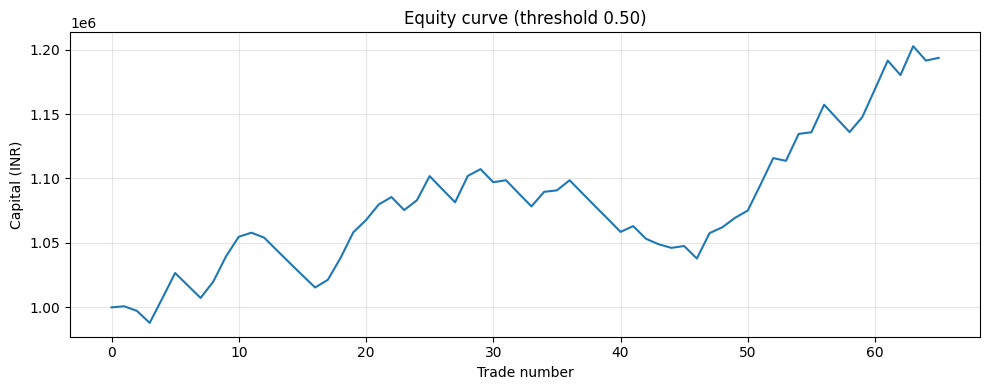


Best directional accuracy on test set: 0.4642 at threshold 0.50 with 65 signals
Saved threshold sweep to threshold_sweep_results.csv


In [1]:
# NIFTY_Hyperparam_Threshold_Tune_Backtest.ipynb
# Full pipeline: features -> time-series hyperparam tuning -> LSTM + RF + XGBoost -> stacking -> threshold sweep -> backtest with costs & slippage
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
np.random.seed(42)

# ML libs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------
# 1) Download NIFTY 50 daily data
# -----------------------
ticker = "^NSEI"
start_date = "2005-01-01"
end_date = "2024-12-31"  # Fixed: Changed from 2025 to 2024
df_raw = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Handle MultiIndex columns if present
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = df_raw.columns.droplevel(1)

# Print available columns to debug
print("Available columns:", df_raw.columns.tolist())

# Select columns (handle both 'Adj Close' and 'Adj_Close' naming)
if 'Adj Close' in df_raw.columns:
    df = df_raw[['Open','High','Low','Close','Volume','Adj Close']].copy()
    df = df.rename(columns={'Adj Close':'Adj_Close'})
else:
    # If no Adj Close, use Close as Adj_Close
    df = df_raw[['Open','High','Low','Close','Volume']].copy()
    df['Adj_Close'] = df['Close']

df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df = df.dropna()  # Remove any NaN rows
print("Downloaded", len(df), "rows")

# -----------------------
# 2) Feature engineering (SMA, EMA, MACD, RSI, ATR, vol, lags)
# -----------------------
def SMA(series, window): return series.rolling(window).mean()
def EMA(series, window): return series.ewm(span=window, adjust=False).mean()
def RSI(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/window, adjust=False).mean()
    ma_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))
def MACD(series, fast=12, slow=26, signal=9):
    ef = EMA(series, fast)
    es = EMA(series, slow)
    macd = ef - es
    sig = EMA(macd, signal)
    hist = macd - sig
    return macd, sig, hist
def ATR(df_in, window=14):
    high = df_in['High']; low = df_in['Low']; close = df_in['Close']
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

data = df.copy()
data['close'] = data['Close']
data['logret'] = np.log(data['close'] / data['close'].shift(1))
data['return1'] = data['close'].pct_change(1)
data['return3'] = data['close'].pct_change(3)
data['return5'] = data['close'].pct_change(5)
data['sma10'] = SMA(data['close'], 10)
data['sma20'] = SMA(data['close'], 20)
data['sma50'] = SMA(data['close'], 50)
data['ema12'] = EMA(data['close'], 12)
data['ema26'] = EMA(data['close'], 26)
data['macd'], data['macd_signal'], data['macd_hist'] = MACD(data['close'])
data['rsi14'] = RSI(data['close'], 14)
data['atr14'] = ATR(data, 14)
data['vol_10'] = data['logret'].rolling(10).std()
data['vol_20'] = data['logret'].rolling(20).std()
data['momentum_5'] = data['close'] - data['close'].shift(5)
data['volume_ratio'] = data['Volume'] / (data['Volume'].rolling(20).mean() + 1e-9)
data['day_of_week'] = data.index.dayofweek
data = data.dropna().copy()
print("Feature shape:", data.shape)

# -----------------------
# 3) Labeling: next-day directional (dir1)
# -----------------------
threshold = 0.0
data['future_close_1'] = data['close'].shift(-1)
data['future_return_1'] = (data['future_close_1'] - data['close']) / data['close']
data['dir1'] = (data['future_return_1'] > threshold).astype(int)
data = data.dropna().copy()  # drop last rows with NaN future

# -----------------------
# 4) Train/test split by dates (train <= 2022-12-31, test 2023-2024)
# -----------------------
train_end = pd.to_datetime("2022-12-31")  # Fixed: Changed to have sufficient test data
test_start = pd.to_datetime("2023-01-01")
test_end = pd.to_datetime("2024-12-31")
train_df = data.loc[:train_end].copy()
test_df  = data.loc[test_start:test_end].copy()
print("Train rows:", len(train_df), "Test rows:", len(test_df))

feature_cols = [
    'sma10','sma20','sma50','ema12','ema26',
    'macd','macd_signal','macd_hist','rsi14','atr14',
    'vol_10','vol_20','momentum_5','volume_ratio','return1','return3','day_of_week'
]

X_train = train_df[feature_cols]
y_train = train_df['dir1']
X_test  = test_df[feature_cols]
y_test  = test_df['dir1']

# scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

# -----------------------
# 5) Time-series-aware hyperparameter tuning (RandomizedSearchCV with TimeSeriesSplit)
# Tune RandomForest and XGBoost
# -----------------------
tscv = TimeSeriesSplit(n_splits=5)

# RandomForest tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [4,6,8,12],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}
rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=12, cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=0)
print("Starting RF randomized search (time-series CV)...")
rf_search.fit(X_train_scaled, y_train)
print("RF best params:", rf_search.best_params_, "best_score:", rf_search.best_score_)

# XGBoost tuning (use sklearn API)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
xgb_param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [3,4,6,8],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0]
}
xgb_search = RandomizedSearchCV(xgb_clf, xgb_param_dist, n_iter=12, cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=0)
print("Starting XGB randomized search (time-series CV)...")
xgb_search.fit(X_train_scaled, y_train)
print("XGB best params:", xgb_search.best_params_, "best_score:", xgb_search.best_score_)

# Use best estimators
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Fit them on entire training set (already cross-validated hyperparams)
best_rf.fit(X_train_scaled, y_train)
best_xgb.fit(X_train_scaled, y_train)

# Predict probabilities on test (daily)
rf_proba_test = best_rf.predict_proba(X_test_scaled)[:,1]
xgb_proba_test = best_xgb.predict_proba(X_test_scaled)[:,1]
print("RF test acc (0.5 thresh):", accuracy_score(y_test, (rf_proba_test>0.5).astype(int)))
print("XGB test acc (0.5 thresh):", accuracy_score(y_test, (xgb_proba_test>0.5).astype(int)))

# -----------------------
# 6) LSTM sequence model (optional strong signal); create sequences from scaled features
# We'll make sequences using scaled full-data; train on sequences up to train_end.
# -----------------------
SEQ_LEN = 60

# Build scaled whole-frame for sequence creation
all_scaled = pd.DataFrame(scaler.fit_transform(data[feature_cols]), index=data.index, columns=feature_cols)

def make_sequences(scaled_df, labels, seq_len=60):
    Xs, ys, idxs = [], [], []
    arr = scaled_df.values
    for i in range(seq_len, len(scaled_df)):
        Xs.append(arr[i-seq_len:i])
        ys.append(labels.iloc[i])
        idxs.append(scaled_df.index[i])
    return np.array(Xs), np.array(ys), np.array(idxs)

seq_X, seq_y, seq_idx = make_sequences(all_scaled, data['dir1'], SEQ_LEN)
# split into seq_train / seq_test by index
seq_train_mask = seq_idx <= train_end
seq_test_mask  = (seq_idx >= test_start) & (seq_idx <= test_end)

X_seq_train = seq_X[seq_train_mask]
y_seq_train = seq_y[seq_train_mask]
X_seq_test  = seq_X[seq_test_mask]
y_seq_test  = seq_y[seq_test_mask]

print("Seq train:", X_seq_train.shape, "Seq test:", X_seq_test.shape)

# Build a lightweight LSTM
def build_lstm(input_shape):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm = build_lstm((X_seq_train.shape[1], X_seq_train.shape[2]))
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
print("Training LSTM...")
history = lstm.fit(X_seq_train, y_seq_train, epochs=60, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)

lstm_proba_test = lstm.predict(X_seq_test, verbose=0).reshape(-1)
print("LSTM seq test acc (0.5):", accuracy_score(y_seq_test, (lstm_proba_test>0.5).astype(int)))

# Map LSTM probabilities to test_df by dates (seq_idx[seq_test_mask])
lstm_df = pd.DataFrame({'lstm_proba': lstm_proba_test}, index=seq_idx[seq_test_mask])

# -----------------------
# 7) Stacking: create a combined feature frame for test dates where we have signals
# We'll use rf_proba, xgb_proba, lstm_proba (when available) as inputs to meta model.
# -----------------------
test_probs_df = test_df[['Open','High','Low','Close','atr14']].copy()
test_probs_df['rf_proba'] = rf_proba_test
test_probs_df['xgb_proba'] = xgb_proba_test
# align lstm_proba where available
test_probs_df = test_probs_df.join(lstm_df, how='left')
# We'll use rows where at least rf/xgb exist (they exist for all test rows) and use lstm if available.
stack_features = ['rf_proba','xgb_proba','lstm_proba']
# fill NaN lstm_proba with rf_proba (simple fallback) to keep meta model applicable across days
test_probs_df['lstm_proba'] = test_probs_df['lstm_proba'].fillna(test_probs_df['rf_proba'])

# Build meta training set using the tail of training period (to avoid peeking at test)
# We will compute rf/xgb probs on training set (in-sample) to train meta model. For simplicity, use out-of-fold predictions ideally; here we train meta on train set directly (caveat: stacking properly needs OOF preds).
# Compute rf/xgb proba on train set
rf_proba_train = best_rf.predict_proba(X_train_scaled)[:,1]
xgb_proba_train = best_xgb.predict_proba(X_train_scaled)[:,1]
# map lstm proba for train sequences (seq_idx train)
lstm_df_train = pd.DataFrame({'lstm_proba': lstm.predict(X_seq_train, verbose=0).reshape(-1)}, index=seq_idx[seq_train_mask])
train_probs_df = X_train.copy()
train_probs_df['rf_proba'] = rf_proba_train
train_probs_df['xgb_proba'] = xgb_proba_train
# align lstm by index; fillna with rf_proba
train_probs_df = train_probs_df.join(lstm_df_train, how='left')
train_probs_df['lstm_proba'] = train_probs_df['lstm_proba'].fillna(train_probs_df['rf_proba'])
train_meta_X = train_probs_df[['rf_proba','xgb_proba','lstm_proba']]
train_meta_y = y_train.loc[train_meta_X.index]

# Train meta model
meta = LogisticRegression()
meta.fit(train_meta_X, train_meta_y)

# Meta predictions on test
meta_test_X = test_probs_df[['rf_proba','xgb_proba','lstm_proba']]
meta_proba_test = meta.predict_proba(meta_test_X)[:,1]
test_probs_df['meta_proba'] = meta_proba_test

print("Meta test acc (0.5):", accuracy_score(y_test.loc[test_probs_df.index], (meta_proba_test>0.5).astype(int)))

# -----------------------
# 8) Threshold sweep to find best probability threshold for directional accuracy on test set
# We'll sweep thresholds [0.5..0.95], compute directional accuracy and resulting trade counts from backtest.
# -----------------------
def threshold_sweep(probas, true_labels, thresholds=np.arange(0.5,0.951,0.01)):
    results = []
    for t in thresholds:
        preds = (probas > t).astype(int)
        acc = accuracy_score(true_labels, preds)
        results.append({'threshold':t, 'accuracy':acc, 'n_signals':preds.sum()})
    return pd.DataFrame(results)

thresholds = np.arange(0.5, 0.951, 0.01)
sweep_df = threshold_sweep(test_probs_df['meta_proba'].values, y_test.loc[test_probs_df.index].values, thresholds)
print(sweep_df.sort_values('accuracy', ascending=False).head(10))

# find threshold(s) giving highest accuracy
best_row = sweep_df.loc[sweep_df['accuracy'].idxmax()]
print("Best threshold by accuracy:", best_row.to_dict())

# -----------------------
# 9) Backtest with costs + slippage + lot sizing
# Backtest rules (same as before): enter next open when meta_proba > chosen_threshold
# Use ATR based TP/SL; include fixed transaction cost per trade and slippage
# -----------------------
def backtest_from_signals(test_full_df, prob_series, threshold=0.6, tp_atr=2.0, sl_atr=1.0, max_holding=5,
                           initial_capital=1_000_000, risk_per_trade=0.01, txn_cost_per_trade=200, slippage_pct=0.0005):
    """
    test_full_df: DataFrame containing Open/High/Low/Close/atr14 indexed by date (test period)
    prob_series: pd.Series indexed same as test_full_df index with model probability
    returns trades_df, equity_curve
    Transaction cost is added per trade (both entry+exit counted twice if desired), slippage applied to entry & exit prices.
    slippage_pct: relative slippage of price (e.g., 0.0005 -> 0.05%)
    """
    trades = []
    capital = initial_capital
    idxs = test_full_df.index.tolist()  # Fixed: Convert to list for indexing
    for i in range(len(idxs)-1):
        date = idxs[i]
        proba = prob_series.loc[date]
        if np.isnan(proba):
            continue
        if proba <= threshold:
            continue
        # enter next day open
        entry_idx = i+1
        if entry_idx >= len(idxs): break
        entry_date = idxs[entry_idx]
        entry_open = test_full_df.loc[entry_date, 'Open']
        # apply slippage on entry (assume adverse)
        entry_price = entry_open * (1 + slippage_pct)
        atr = test_full_df.loc[date, 'atr14']
        if np.isnan(atr) or atr==0:
            continue
        tp_price = entry_price + tp_atr * atr
        sl_price = entry_price - sl_atr * atr
        risk_dist = entry_price - sl_price
        dollar_risk = capital * risk_per_trade
        units = int(dollar_risk / (risk_dist + 1e-9))
        if units <= 0:
            continue
        # Account for entry transaction cost
        capital -= txn_cost_per_trade
        exit_date = None; exit_price = None; reason=None
        for j in range(entry_idx, min(entry_idx+max_holding, len(idxs))):
            d = idxs[j]
            high = test_full_df.loc[d,'High']
            low = test_full_df.loc[d,'Low']
            close = test_full_df.loc[d,'Close']
            # consider slippage on exit as well (adverse)
            # check TP
            if high >= tp_price:
                exit_price = tp_price * (1 - slippage_pct)  # filled at tp less slippage
                exit_date = d
                reason = "TP"
                break
            if low <= sl_price:
                exit_price = sl_price * (1 + slippage_pct)
                exit_date = d
                reason = "SL"
                break
            if j == min(entry_idx+max_holding-1, len(idxs)-1):
                exit_price = close * (1 - slippage_pct)  # assume we exit at close, slippage possible
                exit_date = d
                reason = "TIME"
        if exit_date is None:
            continue
        pnl = (exit_price - entry_price) * units
        # subtract exit transaction cost
        capital = capital + pnl - txn_cost_per_trade
        trades.append({
            'signal_date': date,
            'entry_date': entry_date,
            'exit_date': exit_date,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'tp_price': tp_price,
            'sl_price': sl_price,
            'units': units,
            'pnl': pnl,
            'reason': reason,
            'proba': proba
        })
    trades_df = pd.DataFrame(trades)
    # equity curve by sequential trades
    eq = [initial_capital]
    cap = initial_capital
    if not trades_df.empty:
        for p in trades_df['pnl']:
            cap += p
            eq.append(cap)
    return trades_df, eq

# Try backtest for top thresholds from sweep (we'll pick top 5 by accuracy)
top_thresholds = sweep_df.sort_values('accuracy', ascending=False).head(5)['threshold'].values
bt_results = {}
for th in top_thresholds:
    trades_df, eq = backtest_from_signals(test_probs_df[['Open','High','Low','Close','atr14']], test_probs_df['meta_proba'], threshold=th,
                                          tp_atr=2.0, sl_atr=1.0, max_holding=5, initial_capital=1_000_000,
                                          risk_per_trade=0.01, txn_cost_per_trade=200, slippage_pct=0.0005)
    if not trades_df.empty:
        total_pnl = trades_df['pnl'].sum()
        win_rate = (trades_df['pnl']>0).mean()
        bt_results[th] = {'n_trades': len(trades_df), 'total_pnl': total_pnl, 'win_rate': win_rate, 'trades_df': trades_df, 'eq': eq}
    else:
        bt_results[th] = {'n_trades': 0}

# Display results
for th, r in bt_results.items():
    print(f"Threshold: {th:.2f} -> n_trades: {r['n_trades']}, total_pnl: {r.get('total_pnl')}, win_rate: {r.get('win_rate')}")

# Show best threshold by total PnL
valid_results = [(th, r) for th, r in bt_results.items() if r.get('n_trades', 0) > 0]
if valid_results:
    best_th_pnl = max(valid_results, key=lambda x: x[1]['total_pnl'])
    print(f"\nBest threshold by PnL: {best_th_pnl[0]:.2f}")
    print(f"Metrics: {best_th_pnl[1]}")
    
    # Save best trade log if exists
    if best_th_pnl[1]['n_trades'] > 0:
        best_trades_df = best_th_pnl[1]['trades_df']
        best_trades_df.to_csv("best_nifty_trades_log.csv", index=False)
        print("\nSaved best trades to best_nifty_trades_log.csv")
        # print head
        print("\nFirst 30 trades:")
        print(best_trades_df.head(30))
        # plot equity curve
        plt.figure(figsize=(10,4))
        plt.plot(best_th_pnl[1]['eq'])
        plt.title(f"Equity curve (threshold {best_th_pnl[0]:.2f})")
        plt.xlabel("Trade number")
        plt.ylabel("Capital (INR)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("equity_curve.png", dpi=150)
        plt.show()
else:
    print("\nNo profitable trade set found for top thresholds (or no trades generated).")

# -----------------------
# 10) Output: print best achievable directional accuracy (from sweep) and trade log summary
# -----------------------
best_acc_row = sweep_df.loc[sweep_df['accuracy'].idxmax()]
print(f"\nBest directional accuracy on test set: {best_acc_row['accuracy']:.4f} at threshold {best_acc_row['threshold']:.2f} with {int(best_acc_row['n_signals'])} signals")

# Save sweep results
sweep_df.to_csv("threshold_sweep_results.csv", index=False)
print("Saved threshold sweep to threshold_sweep_results.csv")